In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import time

In [21]:
def process_image(fgmask,x,y,count):
    ### Function enforces binarization of background substraction, and removes noise from the background
    ### Also re-binarization to remove shadows and draw contours
    #init variables and modify shapes
    area_dummy = []
    example = np.zeros_like(np.stack((fgmask,fgmask,fgmask),axis=-1))  
    cx = 0
    cy = 0
    final_img = np.stack((fgmask,fgmask,fgmask),axis=-1)
    kernel = np.ones((5,5),np.uint8)
    kernel_1 = np.ones((5,5),np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)
    
    #Enforce BG substraction and remove nosie
    final_img = cv2.morphologyEx(final_img, cv2.MORPH_OPEN, kernel)
    final_img = cv2.morphologyEx(final_img, cv2.MORPH_CLOSE, kernel_1)
    final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2GRAY)
    
    #Re-bin to remove noise
    ret,final_img = cv2.threshold(final_img, 200, 255, cv2.THRESH_BINARY)
    
    #find controus
    contours,_ = cv2.findContours(final_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #Find the largest contour, draw circle and find x and y coords
    for i in contours:
        area_dummy.append(np.array(cv2.contourArea(i)).astype(int))
                           
    if len(area_dummy)>0:
        index = np.argmax(np.array(area_dummy))  

        M = cv2.moments(contours[index])
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])

        cv2.drawContours(example, contours[index],  -1, (0, 255, 0), 3)
        cv2.circle(example, (cx, cy), 7, (0, 0, 255), -1)
        if count>1:
            cv2.line(example, (x[-1],y[-1]), (cx,cy),(0, 0, 255), 3)
            if count>2:
                cv2.line(example, (x[-2],y[-2]), (x[-1],y[-1]),(0, 0, 255), 3)
                if count>3:
                    cv2.line(example, (x[-3],y[-3]), (x[-2],y[-2]),(0, 0, 255), 3)
    
    #return: contours with black BG, final binarization, and coordinates
    return example,final_img,[cx,cy]



SyntaxError: invalid syntax (<ipython-input-21-e897d11f4d36>, line 15)

In [22]:
#File path: change this
file_path = "C:/Users/lehtona6/Dropbox (Aalto)/climbing_project_data_share/online_videos/boulder_example_2.mp4"

#Init variable, video reader, and BG substration
x = []
y= []
count = 0

cap = cv2.VideoCapture(file_path)
fps = cap.get(cv2.CAP_PROP_FPS)

fgbg =  cv2.createBackgroundSubtractorKNN(detectShadows = False)
#fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows = False)
#fgbg = cv2.createBackgroundSubtractorMOG()
#fgbg = cv2.bgsegm.createBackgroundSubtractorGMG(detectShadows = False)

#Open video and read frame by frame
while cap.isOpened():
    ret,frame = cap.read()
    if ret == False:
        break
    if count == 1:
        frame_size = frame.shape
        second_frame = frame
    
    org_frame = frame.copy()
    
    #Blur image for edge detection
    frame = cv2.GaussianBlur(frame, (5, 5),
                       cv2.BORDER_DEFAULT)
    
    #Reduce background
    fgmask = fgbg.apply(frame)
    
    #process image
    contour_image,filtered, coords = process_image(fgmask,x,y,count)
    
    if count<100:
        contour_image = np.zeros_like(contour_image)
    
    #save coordinates
    x.append(coords[0])
    y.append(coords[1])
    
    #Process layout of displayed image
    filtered = np.stack((filtered,filtered,filtered),axis=-1) 
    fgmask = np.stack((fgmask,fgmask,fgmask),axis=-1)
    final_img = cv2.hconcat([org_frame,filtered,contour_image])
    final_img=cv2.resize(final_img, (720,520), interpolation = cv2.INTER_AREA)
    
    #display
    cv2.imshow('window-name', final_img)
    
    count += 1
    
    #"q" to close the video
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows() # destroy all opened windows


<ipython-input-15-06d8a63fe86d>:38: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax2.annotate('Start', xy=(start_loc_1,start_loc_2), xytext=(250, 1000),fontsize = 15,color= "red",
<ipython-input-15-06d8a63fe86d>:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax2.annotate('End', xy=(end_loc_1,end_loc_2), xytext=(250, 900),fontsize = 15,color= "red",


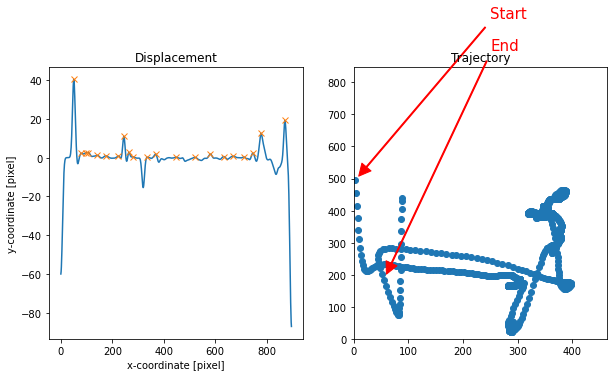

Estimated climbing time: 27.397141796585004 s


In [15]:
#Find the starting point and ending point of the event and plot it with trajectories

#Create time vector
frame_time = 1/fps


#init figure
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5))

#Smooth the noise
disp = gaussian_filter(np.diff(np.sqrt(np.array(x)**2+np.array(y)**2)),5)
time_vector = np.arange(0,len(disp)*1/fps,frame_time)
#Find and plot the velocity peaks that correspond to start and end
ax1.plot(disp)
peaks, _ = find_peaks(disp, height=0)
ax1.set_title("Displacement")
ax1.plot(peaks, disp[peaks], "x")
ax1.set_xlabel("Index of observation")
ax1.set_ylabel("Displacement [pixel]")

#Plot trajecties
ax2.set_title("Trajectory")

start = np.where(disp == np.sort(disp[peaks])[-2:][1])[0][0]
end = np.where(disp == np.sort(disp[peaks])[-2:][0])[0][0]
ax2.scatter(gaussian_filter(np.array(x),5)[start:],gaussian_filter(np.array(np.max(y)-y),5)[start:])
ax2.set_ylim(0,frame_size[0])
ax2.set_xlim(0,frame_size[1])

ax1.set_ylabel("y-coordinate [pixel]")
ax1.set_xlabel("x-coordinate [pixel]")

start_loc_1 = gaussian_filter(np.array(x),5)[start]
start_loc_2 = gaussian_filter(np.array(np.max(y)-y),5)[start]
end_loc_1 = gaussian_filter(np.array(x),5)[end]
end_loc_2 = gaussian_filter(np.array(np.max(y)-y),5)[end]

ax2.annotate('Start', xy=(start_loc_1,start_loc_2), xytext=(250, 1000),fontsize = 15,color= "red",
            arrowprops=dict(facecolor='black', shrink=0.025, width=1,color= "red"))

ax2.annotate('End', xy=(end_loc_1,end_loc_2), xytext=(250, 900),fontsize = 15,color= "red",
            arrowprops=dict(facecolor='black', shrink=0.025, width=1,color= "red"))

#Time between start and end
time = np.abs(time_vector[np.where(disp == np.sort(disp[peaks])[-2:][0])[0][0]]-time_vector[np.where(disp == np.sort(disp[peaks])[-2:][1])[0][0]])

plt.show()
print("Estimated climbing time:", time,"s")

## Ideas and problems

1. Espicially in the beging BG substraction tangles
2. How to find start and end points when:
    - There is lot of noise in the beggining
    - Object does not jump down
    - Object walks into the frame
3. How to deal if the object have the same color clothes as the wall
4. What if the is multiple targets
    - Use the size of the contour, location, and ... to compare euclidean distance between candidates and choose the shortest
    -nearest neighbour, avg frame to frame displacement, average NN
5. What other information can we get from the video than displacement
    - Detect the holds?
6. Overlay frame with the trajectory to see draw the climbing path
7. In test data _2, the crashpad was the same color as clothes. Bin was bad




### Just reduce the first frame ...

In [31]:
#File path: change this
file_path = "C:/Users/lehtona6/Dropbox (Aalto)/climbing_project_data_share/online_videos/boulder_example_2.mp4"

#Init variable, video reader, and BG substration

count = 0

cap = cv2.VideoCapture(file_path)
fps = cap.get(cv2.CAP_PROP_FPS)

#Open video and read frame by frame
while cap.isOpened():
    ret,frame = cap.read()
    if ret == False:
        break
    if count == 0:
        first_frame = frame.copy()
        first_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
        first_gray = cv2.GaussianBlur(first_gray, (5, 5), 0)
    else:    
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)
        difference = cv2.absdiff(first_gray, gray_frame)
        _, difference = cv2.threshold(difference, 25, 255, cv2.THRESH_BINARY)
        difference = np.stack((difference,difference,difference),axis=-1)
        final_img = cv2.hconcat([first_frame,frame,difference])
        final_img=cv2.resize(final_img, (720,520), interpolation = cv2.INTER_AREA)

        #display
        cv2.imshow('window-name', final_img)

        #"q" to close the video
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    count += 1

cap.release()
cv2.destroyAllWindows() # destroy all opened windows


## Template matching

In [ ]:
  def crop_targets(self):
        
        while(frame_count<self.metadata["z_stack"]):
            self.boolean = self.read_frame()
            if self.boolean == False:
                break
            image = np.copy(self.frame)
            if self.FB != []:
                for i in np.arange(len(self.FB)):
                    cv2.rectangle(image, self.FB[i][0],self.FB[i][1], (255, 0, 0), 4)
            
            cv2.imshow('win',image)

            k = cv2.waitKey(0) & 0xff
            
            if k == ord("q"):
                self.close_all()
                break
            elif k == ord('s'):
                continue

            frame_count += 1

        viz_crops(image,self.FB,self.args.save_folder)

In [28]:
class cropper:
    
    def __init__(self):
        self.refPt = None
        self.FB = []
        self.frame = None
        
    def mousePoints(self,event,x,y,flags, param):
        # Left button click for crops
        if event == cv2.EVENT_LBUTTONDOWN:
            self.refPt = [(x, y)]
        elif event == cv2.EVENT_LBUTTONUP:
            self.refPt.append((x, y))
            self.FB.append((self.refPt[0],self.refPt[1]))
            cv2.rectangle(self.frame, self.refPt[0], self.refPt[1], (0, 255, 0), 4)
            cv2.imshow("win", self.frame)
        elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
            clone = np.copy(self.frame)
            cv2.rectangle(clone, self.refPt[0], (x, y), (0, 255, 0), 4)
            cv2.imshow("win", clone) 

        
    def find_feature(self,file_path):
        
        cv2.namedWindow('win',cv2.WINDOW_NORMAL)
        cap = cv2.VideoCapture(file_path)
        cv2.setMouseCallback("win", self.mousePoints)

        #Open video and read frame by frame
        while cap.isOpened():
            ret,self.frame = cap.read()
            if ret == False:
                break
            
            image = self.frame.copy()

            if self.FB != []:
                print("cropping")
                cv2.rectangle(image, self.FB[0][0],self.FB[0][1], (255, 0, 0), 4)
                cv2.imshow('win', image)
                time.sleep(5)
                return image[self.FB[0][0][1]:self.FB[0][1][1],self.FB[0][0][0]:self.FB[0][1][0]]


            #display
            cv2.imshow('win', image)
            k = cv2.waitKey(0) & 0xff
            
            if k == ord("q"):
                cap.release()
                cv2.destroyAllWindows() # destroy all opened windows
                print("You did not frame the template")
                return image
            elif k == ord('s'):
                continue

        

In [77]:
file_path = "C:/Users/lehtona6/Dropbox (Aalto)/climbing_project_data_share/online_videos/boulder_example_2.mp4"
crop_boy = cropper()

template = crop_boy.find_feature(file_path)[:,:,0]

colors = [(114,229,239), (139,18,58), (143,202,64), 
(118,42,172), (81,243,16), (235,107,230), (35,94,49),
(197,213,240),(62,71,86), (13,243,143), (241,67,48),
(11,164,126), (250,33,127), (215,199,123),
(27,77,171), (250,175,227)]
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

#Init variable, video reader, and BG substration
count = 0

cap = cv2.VideoCapture(file_path)
fps = cap.get(cv2.CAP_PROP_FPS)
template = template_draft.copy()
w, h = template.shape[::-1]

#Open video and read frame by frame
while cap.isOpened():
    ret,frame = cap.read()
    if ret == False:
        break
    img = frame[:,:,0].copy()
        
    for counter,meth in enumerate(methods):
        image = img.copy()
        method = eval(meth)

        # Apply template Matching
        res = cv2.matchTemplate(image,template,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc

        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(frame,top_left, bottom_right, colors[counter], 5)

    #display
    cv2.imshow('window-name', frame)

    #"q" to close the video
    k = cv2.waitKey(1) & 0xff

    if k == ord("q"):
        break
    elif k == ord('s'):
        continue
    
    count += 1

cap.release()
cv2.destroyAllWindows() # destroy all opened windows

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
cropping


In [75]:
cap.release()
cv2.destroyAllWindows()

## Optical flow: Lucas-Kanade

removing 0
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
[453.01474     2.7969704]
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
[183.9019 157.6526]
removing 0
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
[453.0431      2.5762286]
rem

removing 0
removing 1
removing 2
removing 3
removing 4
[ 84.56743 485.77347]
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
[ 91.171684 486.51736 ]
removing 6
removing 7
removing 8
[ 70.01295 664.9667 ]
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
[ 97.66343 486.87613]
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
[101.75359 489.70706]
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
[105.03354 490.537  ]
removing 6
removing 7
removing 8
removing 9
removing 10
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
removing 4
[107.867424 491.00726 ]
removing 6
removing 7
removing 8
removing 9
removing 10
removin

removing 9
[305.6675  465.35632]
[257.23474 378.0978 ]
[293.46826 421.26212]
removing 13
removing 0
removing 1
[261.3578  378.32553]
removing 3
[308.98386 467.44284]
[297.59375 502.65744]
[ 11.036273 161.04155 ]
[305.97504 458.03885]
[266.02753 611.79614]
[ 70.28995 664.83905]
[306.66885 465.01196]
[260.01337 378.63226]
[295.88657 421.0082 ]
[183.84273 158.17555]
removing 0
removing 1
[263.67865 379.07898]
removing 3
[309.27496 466.32648]
[299.46298 502.35495]
removing 6
[307.49564 458.19147]
[274.42856 615.8593 ]
removing 9
[307.53485 465.0174 ]
[262.36322 379.43387]
[298.47186 421.16873]
removing 13
removing 0
removing 1
[265.57114 379.9709 ]
removing 3
[309.754   465.44223]
[301.03348 502.0544 ]
removing 6
[309.04788 458.3689 ]
[273.52945 624.434  ]
[ 70.06485 664.84045]
[308.4526  464.83755]
[264.29297 380.23828]
[300.97278 421.69812]
[183.77754 157.93983]
removing 0
removing 1
[267.41702 380.89548]
removing 3
[310.62985 465.2373 ]
[302.65442 501.95535]
removing 6
[310.51273 458.71

removing 0
removing 1
removing 2
removing 3
removing 4
removing 5
removing 6
removing 7
removing 8
removing 9
removing 10
[266.17398 392.83588]
removing 12
removing 13
removing 0
removing 1
[264.20325 395.02887]
removing 3
removing 4
[307.10562 496.51392]
removing 6
removing 7
removing 8
removing 9
removing 10
[266.1559  393.04593]
removing 12
removing 13
removing 0
removing 1
[264.17227 395.29013]
removing 3
[305.38876 471.9285 ]
[307.3624 496.9252]
removing 6
removing 7
removing 8
removing 9
[304.2029  471.18896]
[266.1366  393.32614]
removing 12
removing 13
removing 0
removing 1
[264.23886 395.6653 ]
removing 3
[305.40677 472.03323]
[307.5664  497.27594]
removing 6
removing 7
removing 8
removing 9
[304.21606 471.30185]
[266.21487 393.74048]
removing 12
removing 13
[453.31958     2.2864566]
removing 1
[264.30618 396.0585 ]
removing 3
removing 4
[307.59814 497.4798 ]
removing 6
removing 7
removing 8
removing 9
removing 10
[266.2889  394.16116]
[308.64542 430.4477 ]
removing 13
[453.31

removing 9
[289.26743 504.34406]
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
[289.75742 504.5944 ]
[272.6964 544.6343]
removing 6
[287.61948 502.7347 ]
[290.48944 591.4765 ]
removing 9
[288.5177  504.88455]
removing 11
removing 12
removing 13
removing 0
removing 1
removing 2
removing 3
[289.08   505.1188]
[271.17154 545.0772 ]
removing 6
[286.89288 503.2595 ]
[291.10355 591.97595]
removing 9
[287.77478 505.38992]
removing 11
removing 12
removing 13
[453.43314     1.8483405]
removing 1
removing 2
removing 3
[288.41678 505.49448]
[270.37445 545.3471 ]
removing 6
[286.25232 503.6575 ]
[291.02612 591.719  ]
removing 9
[287.14594 505.74835]
removing 11
removing 12
removing 13
[453.43512    2.004693]
removing 1
removing 2
removing 3
[287.90277 505.86456]
[269.93024 545.6208 ]
removing 6
[285.7436 504.1241]
[290.87714 589.235  ]
removing 9
[286.64688 506.17554]
removing 11
removing 12
[183.103   156.16321]
[453.45926     1.8256116]
removing 1
removing 2
rem

removing 1
[271.67712 410.24945]
removing 3
[333.46066 425.53336]
[325.66403 496.26685]
removing 6
[332.26077 427.79172]
[305.92453 583.8801 ]
removing 9
[334.041   430.31985]
[270.95978 415.4076 ]
[309.864  422.9366]
removing 13
removing 0
removing 1
[271.82047 410.13742]
removing 3
removing 4
[325.9169 496.2361]
removing 6
removing 7
[306.5446 583.8155]
removing 9
[334.1356 430.4222]
[271.10248 415.37976]
removing 12
removing 13
removing 0
removing 1
[271.96375 410.02774]
removing 3
[333.64453 425.3803 ]
[326.31186 496.1841 ]
removing 6
[332.4788 427.6412]
[306.98776 583.97205]
removing 9
[334.25836 430.0588 ]
removing 11
[309.9451  422.74756]
removing 13
removing 0
removing 1
[272.2092  409.71115]
removing 3
[333.70297 425.25363]
[326.87936 495.87817]
removing 6
[332.53427 427.45166]
[307.2666 584.164 ]
removing 9
[334.3271 429.8937]
[271.39124 415.30618]
[310.04276 422.40863]
removing 13
removing 0
removing 1
[272.5645 409.1788]
removing 3
[333.9406  425.04504]
[327.47983 495.52783

removing 13
removing 0
removing 1
removing 2
removing 3
[371.0043 394.0595]
[368.24127 480.0848 ]
removing 6
[370.8247 396.8776]
[319.06244 500.62234]
removing 9
[373.29468 399.92197]
removing 11
[351.54626 386.37317]
removing 13
removing 0
removing 1
removing 2
removing 3
[371.64108 393.6319 ]
[368.9025  479.72134]
removing 6
[371.4965  396.45865]
[319.6875  500.70804]
removing 9
[373.93872 399.5742 ]
removing 11
[352.08154 385.7981 ]
[180.07413 151.89807]
removing 0
removing 1
[302.23026 375.70773]
removing 3
[372.20654 393.31018]
[369.60413 479.4803 ]
removing 6
[372.01065 396.0653 ]
[320.26547 500.78952]
removing 9
[374.47748 399.19333]
removing 11
[352.37634 385.4658 ]
[180.08684 152.02216]
removing 0
removing 1
[302.35187 375.82236]
removing 3
[372.6309  392.99646]
[370.2649  479.24506]
removing 6
[372.4609  395.74237]
[320.84128 500.8927 ]
removing 9
[374.9153 398.8577]
removing 11
[352.4989  385.16278]
removing 13
removing 0
removing 1
[302.45795 375.9345 ]
removing 3
[372.9727

[403.4903  371.41446]
[336.1801  502.74918]
removing 9
[405.893   373.48352]
removing 11
[384.18286 369.6286 ]
[180.0895  152.03291]
removing 0
removing 1
removing 2
removing 3
[404.4367 368.8134]
[395.61905 467.33615]
removing 6
[404.58002 371.3232 ]
[336.53146 503.37817]
removing 9
[407.08148 373.44366]
removing 11
[385.36365 369.69388]
removing 13
removing 0
removing 1
removing 2
removing 3
[405.4121  368.58942]
[397.68948 466.48587]
removing 6
[405.74774 371.26093]
[336.92413 504.12946]
removing 9
[408.40326 373.5456 ]
removing 11
[386.62143 369.6822 ]
removing 13
removing 0
removing 1
removing 2
removing 3
[406.3057  368.44888]
[400.02933 466.30878]
removing 6
[406.9356 371.3463]
[337.18866 504.565  ]
[ 68.35244 664.83453]
[409.7243 373.8342]
removing 11
[387.82608 369.83252]
[180.10062 151.87802]
removing 0
removing 1
removing 2
removing 3
[407.17877 368.2583 ]
[402.44962 466.13205]
removing 6
[408.18542 371.43094]
[337.43124 504.96988]
removing 9
[411.25952 374.3546 ]
removing 1

removing 1
removing 2
removing 3
[420.64206 329.37885]
[422.95776 422.44308]
removing 6
[424.86115 332.26114]
[344.44666 497.2161 ]
removing 9
[433.54126 344.05753]
removing 11
[408.93314 334.08908]
removing 13
removing 0
removing 1
removing 2
removing 3
[418.30307 325.42856]
[422.40915 420.62173]
removing 6
[422.6309  328.36783]
[344.59857 496.697  ]
removing 9
[432.019   343.32425]
removing 11
[406.7414 331.0262]
[180.4705  152.68272]
removing 0
removing 1
removing 2
removing 3
[415.53397 321.21848]
[421.7697  419.51453]
removing 6
[420.2366  324.27682]
[344.82385 496.23187]
removing 9
[430.31583 342.0632 ]
removing 11
[404.5441  327.78238]
removing 13
removing 0
removing 1
removing 2
removing 3
[413.12817 316.94977]
[421.18445 418.34137]
removing 6
[417.88507 320.07318]
[344.96436 495.39694]
removing 9
[428.45676 341.21194]
removing 11
[402.60126 324.18082]
removing 13
removing 0
removing 1
removing 2
removing 3
[411.03998 313.0494 ]
[420.6199 416.9246]
removing 6
[415.55402 316.036

removing 0
removing 1
removing 2
removing 3
[401.95715 290.8055 ]
[416.02765 394.6095 ]
removing 6
[407.46155 294.20834]
[373.70914 421.8766 ]
removing 9
[415.60742 327.3008 ]
removing 11
[387.7583  294.57642]
[180.75655 153.06612]
removing 0
removing 1
removing 2
removing 3
[401.59894 291.08463]
[415.71945 394.64835]
removing 6
[406.98267 294.39352]
[374.0778  422.40945]
removing 9
[415.1878 327.3352]
removing 11
[387.28104 294.93762]
[180.5625  152.64429]
removing 0
removing 1
removing 2
removing 3
[401.1836  291.17642]
[415.5104  394.69864]
removing 6
[406.49774 294.47998]
[375.41754 423.04993]
removing 9
[414.77972 327.31305]
removing 11
[386.71957 295.17136]
[180.41946 152.37392]
removing 0
removing 1
removing 2
removing 3
[400.8596  291.28964]
[415.35416 394.72818]
removing 6
[406.00348 294.531  ]
[376.69705 423.5536 ]
removing 9
[414.45258 327.28458]
removing 11
[386.45325 295.39383]
removing 13
removing 0
removing 1
removing 2
removing 3
[400.4404  291.22607]
[415.25946 394.775

removing 0
removing 1
removing 2
removing 3
[380.4826  253.87183]
[384.77908 368.95868]
removing 6
[386.572   258.78223]
[374.07285 409.59186]
removing 9
[392.70737 300.36188]
removing 11
[363.99356 254.48204]
removing 13
removing 0
removing 1
removing 2
removing 3
[380.08585 254.0747 ]
[384.3215  369.14203]
removing 6
[386.23117 258.996  ]
[373.77795 409.35352]
removing 9
[392.23502 300.45157]
removing 11
[363.5212  254.62927]
removing 13
removing 0
removing 1
removing 2
removing 3
[379.81964 254.35016]
[383.80167 369.39435]
removing 6
[385.9561  259.25006]
[373.47043 409.13834]
removing 9
[391.88538 300.628  ]
removing 11
[363.1595 254.9264]
removing 13
[453.9206     1.864491]
removing 1
removing 2
removing 3
[379.5762  254.76738]
[383.44028 369.76175]
removing 6
[385.74542 259.65396]
[372.9451 409.37  ]
removing 9
[391.58435 301.03275]
removing 11
[362.74313 255.38643]
removing 13
[453.97794     1.6726809]
removing 1
removing 2
removing 3
[379.4724  255.22375]
[383.10913 370.11026]


removing 0
removing 1
[288.14478 367.18475]
removing 3
[373.81638 257.7354 ]
[351.93658 374.29868]
removing 6
[380.3563  263.14072]
[293.9859 388.2734]
removing 9
[376.86386 303.74844]
[285.2802  368.68405]
[354.7637  256.17578]
removing 13
[453.992       1.8938918]
removing 1
[287.1878  366.90802]
removing 3
[371.94797 255.98984]
[351.46436 373.28494]
removing 6
[378.35446 261.17596]
[293.80862 387.90497]
removing 9
[374.98236 302.32544]
[285.01947 367.71384]
[353.19077 254.57098]
[180.05469 152.42749]
removing 0
removing 1
[286.38528 366.27695]
removing 3
[370.04843 254.14207]
[350.74667 372.29657]
removing 6
[376.41357 259.2229 ]
[292.9857 387.1686]
removing 9
[373.10852 300.6284 ]
[284.41873 366.89526]
[351.51602 253.10243]
removing 13
removing 0
removing 1
[285.61957 365.25192]
removing 3
[367.9529  251.83093]
[350.15158 371.38153]
removing 6
[373.82516 256.17322]
[292.54248 386.7411 ]
removing 9
[371.07507 299.3177 ]
[283.9591  365.58426]
[349.80475 251.49615]
[180.26114 152.7018

removing 0
removing 1
[297.92203 327.84277]
removing 3
[343.98492 243.9549 ]
[378.4097 379.1896]
removing 6
[350.48404 246.54811]
[331.74835 366.99933]
removing 9
[357.51407 290.5011 ]
[297.1347 328.2278]
[330.50314 252.52399]
removing 13
removing 0
removing 1
[298.7755 328.937 ]
removing 3
[344.23303 245.0365 ]
[384.04315 381.2156 ]
removing 6
[350.60516 247.59929]
[332.65054 367.24362]
removing 9
[358.01923 290.65616]
[298.1217  329.30048]
[330.40607 254.41994]
removing 13
removing 0
removing 1
[299.32483 329.46985]
removing 3
[344.41052 245.8991 ]
[389.46472 383.46133]
removing 6
[350.93927 248.51506]
[333.05594 367.39807]
removing 9
[358.53802 290.84982]
[298.56546 329.75977]
[330.6257  255.72849]
[180.35277 152.62457]
removing 0
removing 1
[299.8196  329.57724]
removing 3
[344.82697 245.9311 ]
[394.61658 386.3465 ]
removing 6
[351.32556 248.53214]
[333.85944 367.7016 ]
removing 9
[358.90707 290.97415]
[299.141   329.93427]
[330.94196 256.29947]
removing 13
removing 0
removing 1
[3

removing 1
[307.18    327.84366]
removing 3
[352.43628 226.33717]
[403.23215 393.93527]
removing 6
[357.80457 228.86693]
[335.78882 349.94812]
removing 9
[364.17776 284.7466 ]
[306.10153 327.3485 ]
[342.26205 231.27284]
removing 13
removing 0
removing 1
[306.6635 327.9238]
removing 3
[351.90262 226.1127 ]
[400.46133 393.1917 ]
removing 6
[357.30643 228.7194 ]
[335.38242 349.72427]
removing 9
[363.6789 284.744 ]
[305.57498 327.43356]
[341.56888 231.01772]
[181.01384 153.63594]
removing 0
removing 1
[306.25735 327.9683 ]
removing 3
[351.37955 225.94907]
[398.16653 392.66315]
removing 6
[356.76636 228.63464]
[334.91187 349.5376 ]
removing 9
[363.37677 284.60953]
[305.18018 327.4436 ]
[341.11218 230.75414]
removing 13
removing 0
removing 1
[305.80444 327.9465 ]
removing 3
[350.954   225.79402]
[396.25333 392.69043]
removing 6
[356.4355  228.59181]
[334.5514  349.34634]
removing 9
[362.9795 284.4627]
[304.6998  327.43448]
[340.6447  230.52646]
removing 13
removing 0
removing 1
[305.43686 32

removing 0
removing 1
[309.556   324.02454]
removing 3
[386.43167 189.7379 ]
[391.4445  399.12173]
removing 6
[389.5342  191.91177]
[330.69415 327.22955]
removing 9
[397.0861  272.62347]
[308.29642 323.5658 ]
[372.58932 200.14711]
removing 13
removing 0
removing 1
[310.0742  323.80338]
removing 3
[387.50534 189.7371 ]
[391.5407  399.24747]
removing 6
[390.61893 191.91449]
[331.35196 327.06204]
removing 9
[398.16977 272.59024]
[308.7608  323.52304]
[373.80798 200.03384]
removing 13
removing 0
removing 1
[310.58987 323.72653]
removing 3
[388.62912 189.7404 ]
[391.67172 399.23254]
removing 6
[391.78052 191.91702]
[331.8758  326.84326]
removing 9
[399.3977 272.6016]
[309.3245  323.49957]
[375.11792 199.82227]
[180.91655 153.57687]
[453.9502     2.017466]
removing 1
[311.08112 323.60233]
removing 3
[389.73727 189.73663]
[391.81653 399.27206]
removing 6
[392.95593 191.90318]
[332.37125 326.68893]
removing 9
[400.649   272.44147]
[309.7357  323.46033]
[376.3554  199.89932]
removing 13
removin

removing 0
removing 1
[326.07925 323.01718]
removing 3
[395.0129  192.81784]
removing 5
removing 6
[399.41122 195.277  ]
[346.2146 327.9303]
removing 9
[417.85135 274.47763]
[324.8185  322.66586]
[380.79684 209.06596]
[180.49835 153.23734]
removing 0
removing 1
[325.8835  322.92908]
removing 3
[394.62634 192.98811]
removing 5
removing 6
[399.0831  195.42484]
[345.88614 327.8235 ]
removing 9
[417.3995  274.40552]
[324.60184 322.582  ]
[380.24963 209.21635]
[180.56966 153.35823]
removing 0
removing 1
[325.72427 322.80518]
removing 3
[394.2176  193.15433]
removing 5
removing 6
[398.70193 195.59949]
removing 8
[ 67.72492 664.814  ]
[416.95114 274.34396]
[324.47256 322.5006 ]
[379.7553  209.27354]
removing 13
removing 0
removing 1
[325.5499  322.62677]
removing 3
[393.86234 193.24844]
removing 5
removing 6
[398.4347  195.70259]
[345.61414 327.75226]
removing 9
[416.53995 274.4195 ]
[324.31375 322.2699 ]
[379.3571  209.40504]
removing 13
removing 0
removing 1
[325.36975 322.3452 ]
removing 3

removing 0
removing 1
[308.2963  364.85458]
removing 3
[385.78284 199.03476]
[391.1495  401.33896]
removing 6
[389.93033 201.4769 ]
[327.59247 363.9113 ]
removing 9
[398.67523 282.7655 ]
[308.36252 358.0759 ]
[370.57187 213.20984]
removing 13
removing 0
removing 1
[307.4922 364.7115]
removing 3
[387.1702 198.1243]
[390.90735 402.12943]
removing 6
[391.2468  200.51793]
[326.3032  360.57318]
removing 9
[397.491   282.23257]
[307.41595 357.66687]
[372.08893 211.10126]
removing 13
removing 0
removing 1
[307.22794 364.75775]
removing 3
[388.6919  196.69507]
[391.13208 402.9175 ]
removing 6
[392.70456 199.09644]
[325.20895 357.03235]
removing 9
[396.0689 281.7002]
[306.7647  357.48123]
[373.40927 208.01393]
removing 13
removing 0
removing 1
[307.4126 364.7898]
removing 3
[390.09763 194.77841]
[392.05707 403.22256]
removing 6
[394.21945 197.2139 ]
[325.6143  353.41718]
[ 67.53342 664.78174]
[394.7044  278.48846]
[306.6128 357.5117]
[374.15732 204.53786]
removing 13
removing 0
removing 1
[307.

removing 9
[287.2115  460.89383]
[459.40372 492.4452 ]
removing 12
[454.14355     1.6824312]
[150.95012  119.948074]
[288.49918 462.74738]
removing 3
[462.76028 488.52826]
[414.20746 656.1539 ]
[ 10.439285 160.88933 ]
[468.598   474.93918]
[ 68.166245 664.87787 ]
[378.62347 354.23373]
[291.23785 455.17358]
[461.6148 492.5559]
[180.34694 153.17747]
removing 0
removing 1
[291.2065  456.65363]
removing 3
[464.6713 488.8569]
[411.77856 655.99304]
removing 6
[ 68.051125 664.882   ]
removing 8
[304.97183 450.1987 ]
[463.24524 492.53662]
removing 11
removing 0
removing 1
[291.40472 454.4388 ]
removing 3
[466.61575 490.21454]
[406.1426 655.7805]
removing 6
[ 67.913414 664.87994 ]
removing 8
[307.48486 447.0353 ]
[463.95932 492.6261 ]
removing 11
removing 0
removing 1
[292.46204 453.49557]
removing 3
[400.68857 655.6493 ]
removing 5
removing 6
[378.5419 354.3729]
[307.90964 445.39468]
[465.46677 494.48376]
removing 10
removing 0
removing 1
[296.29758 454.40137]
removing 3
[397.1018 655.5369]
re

removing 0
removing 1
removing 2
[277.53458 650.1923 ]
removing 4
removing 5
removing 6
removing 7
removing 0
removing 1
removing 2
[276.70822 649.96826]
removing 4
removing 5
removing 6
removing 7
removing 0
removing 1
removing 2
[276.973   650.27576]
removing 4
removing 5
removing 6
[180.30215 152.70326]
removing 0
removing 1
removing 2
[277.48984 650.45795]
removing 4
removing 5
removing 6
removing 7
[454.08832    1.520709]
removing 1
removing 2
[276.9591 650.6498]
removing 4
removing 5
removing 6
[180.18994 152.63176]
removing 0
removing 1
[ 53.653748 123.50695 ]
[276.40497 650.82806]
removing 4
removing 5
removing 6
[179.89674 152.45041]
[454.0979      1.7690196]
removing 1
removing 2
[276.18576 650.90955]
removing 4
removing 5
removing 6
removing 7
removing 0
removing 1
removing 2
[276.07343 651.0037 ]
removing 4
removing 5
removing 6
removing 7
removing 0
removing 1
removing 2
[275.93704 650.9967 ]
removing 4
removing 5
removing 6
removing 7
removing 0
removing 1
removing 2
[275

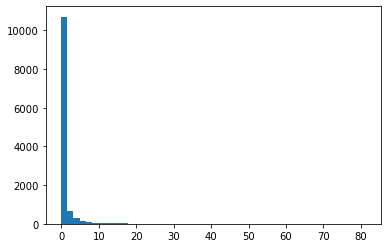

In [75]:
file_path = "C:/Users/lehtona6/Dropbox (Aalto)/climbing_project_data_share/online_videos/boulder_example_2.mp4"


cap = cv2.VideoCapture(file_path)

# params for ShiTomasi corner detection
feature_params = dict(maxCorners = 0,
                       qualityLevel = 0.3,
                       minDistance = 50,
                       blockSize = 50 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 5,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0, 255, (100, 3))

# Take first frame and find corners in it
ret, old_frame = cap.read()

old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
distance = []
mask = np.zeros_like(old_frame)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Select good points
    if p1 is not None:
        good_new = p1[st==1]
        good_old = p0[st==1]

    x_mean = []
    y_mean = []
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        
        distance.append(np.linalg.norm(new-old))
        if distance[-1]<0.1:
            print("removing", i)
            np.delete(good_new,i)
            np.delete(good_old,i)
        else:
            print(new)
            x_mean.append(new[0])
            y_mean.append(new[1])
    
    if len(good_old)<40:
        old_frame = frame_gray
    
    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 2)
        frame = cv2.circle(frame, (int(a), int(b)), 5, color[i].tolist(), -1)
    
    if x_mean != []:
        x_mean = np.array(x_mean).mean()
        y_mean = np.array(y_mean).mean()
        frame = cv2.circle(frame, (int(x_mean), int(y_mean)), 5, (0, 0, 255), -1)

    img = cv2.add(frame, mask)
    cv2.imshow('frame', img)
    k = cv2.waitKey(1) & 0xff
    if k == ord("q"):
        break
    elif k == ord('s'):
        continue
    
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

plt.hist(distance,bins=50)
cap.release()
cv2.destroyAllWindows()

## Opticalflow: Dense

In [83]:
cap = cv2.VideoCapture(file_path)
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[..., 1] = 255
while(1):
    ret, frame2 = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    cv2.imshow('frame2', bgr)
    k = cv2.waitKey(1) & 0xff
    if k == ord("q"):
        break
    elif k == ord('s'):
        continue
    prvs = next
cap.release()    
cv2.destroyAllWindows()

No frames grabbed!


In [82]:
cv2.destroyAllWindows()